In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import csv
import shutil
from pathlib import Path
from IPython.display import Audio, display
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import random

In [3]:
#To have reproducible results with fastai you must also set num_workers=1 in your databunch, and seed=seed
#in split_by_rand_pct
seed = 42
# python RNG
random.seed(seed)
# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
# numpy RNG
np.random.seed(seed)

In [4]:
from fastai.vision import *
from fastai.metrics import error_rate

sys.path.append("..")
from audio import *

# Introduction

In this notebook we will use the library on our first real world dataset to create a model that can identify a broad range of sounds (50 classes including pigs, wind, clapping, chainsaws...etc).


# ESC-50: Dataset for Environmental Sound Classification

**ESC-50** is a really nice starting dataset as it is especially clean (fixed-length, hand-labeled, single sample-rate) and well maintained. Many thanks to [Karol Piczak](https://github.com/karoldvl) for maintaining a really great [Github Repo](https://github.com/karoldvl/ESC-50) based around this dataset. The cell below with spectrograms and labels is taken directly from there, but the page itself is really worth viewing as they keep a leaderboard of different benchmarks/results/papers on the dataset which will allow us to see directly how we measure up.

<div><img src="https://github.com/karoldvl/ESC-50/raw/master/esc50.gif" alt="ESC-50 clip preview" title="ESC-50 clip preview" /></div>

The **ESC-50 dataset** is a labeled collection of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification.

The dataset consists of 5-second-long recordings organized into 50 semantical classes (with 40 examples per class) loosely arranged into 5 major categories:

| <sub>Animals</sub> | <sub>Natural soundscapes & water sounds </sub> | <sub>Human, non-speech sounds</sub> | <sub>Interior/domestic sounds</sub> | <sub>Exterior/urban noises</sub> |
| :--- | :--- | :--- | :--- | :--- |
| <sub>Dog</sub> | <sub>Rain</sub> | <sub>Crying baby</sub> | <sub>Door knock</sub> | <sub>Helicopter</sub></sub> |
| <sub>Rooster</sub> | <sub>Sea waves</sub> | <sub>Sneezing</sub> | <sub>Mouse click</sub> | <sub>Chainsaw</sub> |
| <sub>Pig</sub> | <sub>Crackling fire</sub> | <sub>Clapping</sub> | <sub>Keyboard typing</sub> | <sub>Siren</sub> |
| <sub>Cow</sub> | <sub>Crickets</sub> | <sub>Breathing</sub> | <sub>Door, wood creaks</sub> | <sub>Car horn</sub> |
| <sub>Frog</sub> | <sub>Chirping birds</sub> | <sub>Coughing</sub> | <sub>Can opening</sub> | <sub>Engine</sub> |
| <sub>Cat</sub> | <sub>Water drops</sub> | <sub>Footsteps</sub> | <sub>Washing machine</sub> | <sub>Train</sub> |
| <sub>Hen</sub> | <sub>Wind</sub> | <sub>Laughing</sub> | <sub>Vacuum cleaner</sub> | <sub>Church bells</sub> |
| <sub>Insects (flying)</sub> | <sub>Pouring water</sub> | <sub>Brushing teeth</sub> | <sub>Clock alarm</sub> | <sub>Airplane</sub> |
| <sub>Sheep</sub> | <sub>Toilet flush</sub> | <sub>Snoring</sub> | <sub>Clock tick</sub> | <sub>Fireworks</sub> |
| <sub>Crow</sub> | <sub>Thunderstorm</sub> | <sub>Drinking, sipping</sub> | <sub>Glass breaking</sub> | <sub>Hand saw</sub> |



Clips in this dataset have been manually extracted from public field recordings gathered by the **[Freesound.org project](http://freesound.org/)**. The dataset has been prearranged into 5 folds for comparable cross-validation, making sure that fragments from the same original source file are contained in a single fold.

A more thorough description of the dataset is available in the original [paper](http://karol.piczak.com/papers/Piczak2015-ESC-Dataset.pdf) with some supplementary materials on GitHub: **[ESC: Dataset for Environmental Sound Classification - paper replication data](https://github.com/karoldvl/paper-2015-esc-dataset)**.

# Code to download/install dataset here


In [11]:
PATH_DATA = Path("../data/ESC-50/")

In [17]:
#PATH_BASE = Path("../data/ESC-50/")
PATH_BASE = PATH_DATA
PATH_AUDIO = PATH_BASE/"audio"
PATH_CSV  = PATH_BASE/"meta/esc50.csv"
DF = pd.read_csv(PATH_CSV)

When working with audio, you have to be especially careful not to leak data between your training, validation and test sets. For instance, in ESC-50, some of the clips are generated by splitting up files into several shorter clips (e.g. taking 15 seconds of guitar, and splitting it into three 5 second clips). If those files aren't kept together in one fold, and some end up in training and others in the validation set, our model may learn features we aren't interested in, like background noise, or something particular to the microphone that was used, to identify the label. 

Another example is speaker identification. If you have users record their voices on their own devices and then train a model, it may learn to identify the quirks of their microphone, or their environment, rather than the unique features of their voice. Thus you might have a model with 99.8% accuracy, but when you test it by using input from one device for all speakers, it may fail to generalize. 

In this case the data is split into 5 folds, and any clips that have been split up from one longer original are all together in the same fold. This strict segregation of data will also allow us to compare results to others knowing that we are all using the same validation set. 

## Step 1: Training on a single fold

First we set our spectrogram config. Most of the values below are defaults but I've made them explicit just to show the setup. Since the data is so clean, we need almost nothing for our `AudioConfig`, just caching and passing in the `SpectrogramConfig`

In [14]:
sg_cfg= SpectrogramConfig(hop=512, n_mels=128, n_fft=1024, top_db=80, f_min=20, f_max=22050)
cfg = AudioConfig(cache=True, sg_cfg=sg_cfg)

We can set our validation fold to five and split our files up into Train (folds 1, 2, 3, and 4) and Valid (fold 5). 

In [15]:
VAL_FOLD = 5
FILES_TRAIN = [f for f in DF.loc[DF['fold'] != VAL_FOLD].filename]
FILES_VALID = [f for f in DF.loc[DF['fold'] == VAL_FOLD].filename]
len(FILES_TRAIN), len(FILES_VALID)

(1600, 400)

Next we load up an AudioList with our data, using `split_by_files` to separate valid and training. We don't do any transforms because we will be using mixup, which is made incredibly easy by fastai and works very well for acoustic scene classification.

In my (brief) experience, SpecAugment (putting bars over the spectrogram to hide info as a form of data augmentation) works better for speech data, and has little impact for scenes, but you should experiment further with this and normal fastai image transforms. Most image transforms don't make sense for spectrograms, but some people in our audio thread have reported small gains by using a few limited transforms.


In [19]:
#num_workers = 1 for reproducibility, see https://docs.fast.ai/dev/test.html#getting-reproducible-results
#tfms = get_spectro_transforms(mask_frequency=False, mask_time=False, size=(256,430))
tfms=None
db_audio = (AudioList.from_csv(PATH_AUDIO, "../meta/esc50.csv", config=cfg)
                .split_by_files(FILES_VALID).label_from_df("category")
               .transform(tfms=tfms)
               .databunch(bs=16, num_workers = 1))

You can deactivate this warning by passing `no_check=True`.


/home/user/anaconda3/lib/python3.7/site-packages/fastai/basic_data.py:259: UserWarning: There seems to be something wrong with your dataset, for example, in the first batch can't access any element of self.train_ds.
Tried: 544,498,844,1030,759...
  warn(warn_msg)


In [10]:
db_audio

UnboundLocalError: local variable 'item' referenced before assignment

In [41]:
db_audio.show_batch()

UnboundLocalError: local variable 'item' referenced before assignment

In [42]:
db_audio.train_ds[0][0].shape

UnboundLocalError: local variable 'item' referenced before assignment

In [43]:
db_audio.show_batch(5)

UnboundLocalError: local variable 'item' referenced before assignment

When using mixup on audio, I've found much better results using densenets (121 and 161) but this is without having done a comprehensive search of the available architectures. More work is needed here from the community. Resnets up to resnet50 don't seem to be deep enough as training loss is always higher than validation (I haven't tried lowering other forms of regularization to reduce this)

In [14]:
#learn = cnn_learner(db_audio, models.densenet161, metrics=accuracy, callback_fns=ShowGraph, pretrained=True).mixup()
learn = cnn_learner(db_audio, models.densenet201, metrics=accuracy, callback_fns=ShowGraph, pretrained=True).mixup()

In [ ]:
learn.summary

In [ ]:
#replace 1st layer to change input dimension from 3(R, G, B) to 1(monochrome)
newlayer = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
newlayer = newlayer.cuda() # Our layer should use cuda, since the rest of the model will.
learn.model[0][0][0] = newlayer

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


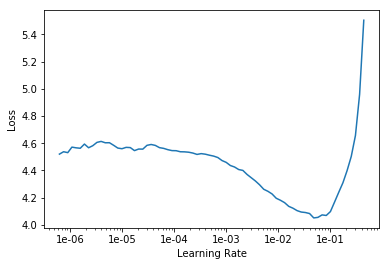

In [15]:
learn.lr_find();
learn.recorder.plot()

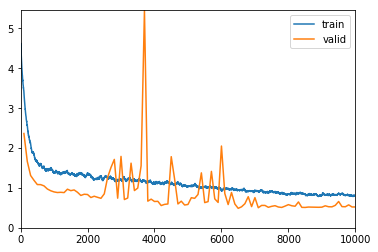

In [16]:
learn.fit_one_cycle(100, slice(1e-2))

In [20]:
learn.save('ESC50-stage1')

In [22]:
#learn.export(PATH_DATA/'models/895peakacc-stg1')
# save model to (ROOT)/data/ESC-50/models/export.pkl
learn.export('../models/export.pkl')

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

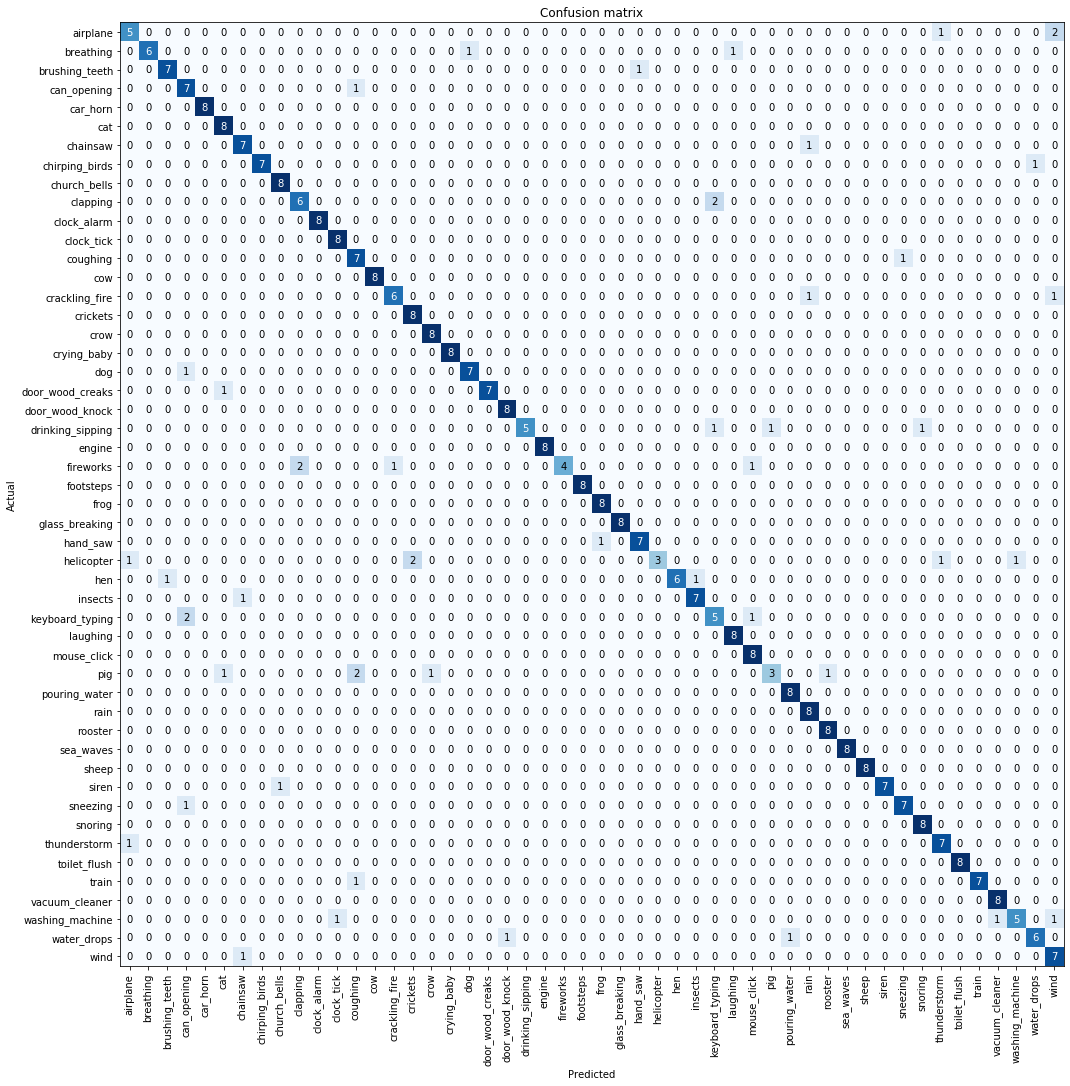

In [25]:
interp.plot_confusion_matrix(figsize=(15,15))

For a closer look at our most frequently confused classes, we can call the aptly named `most_confused` function. All of these seem like classes that could be hard to differentiate, so we are on the right track. 

In [29]:
interp.most_confused(min_val=2)

[('airplane', 'wind', 2),
 ('clapping', 'keyboard_typing', 2),
 ('fireworks', 'clapping', 2),
 ('helicopter', 'crickets', 2),
 ('keyboard_typing', 'can_opening', 2),
 ('pig', 'coughing', 2)]

We can call `plot_top_losses` to both see and hear the clips that are fooling our model. If you listen it becomes clear just how hard some of these are to distinguish. Others seem like something the model shouldn't be getting wrong, and are a good place to start trying to look for ways to improve the model. 

File: ../data/ESC-50/ESC-50-master/audio/5-103420-A-2.wav
Total Length: 5.0 seconds
Label: cat/pig / 6.16 / 0.00


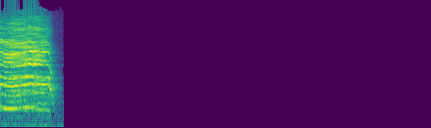

File: ../data/ESC-50/ESC-50-master/audio/5-103416-A-2.wav
Total Length: 5.0 seconds
Label: rooster/pig / 4.98 / 0.01


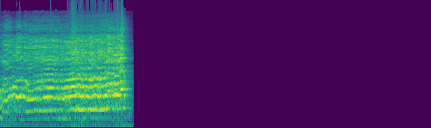

File: ../data/ESC-50/ESC-50-master/audio/5-233787-A-7.wav
Total Length: 5.0 seconds
Label: chainsaw/insects / 4.30 / 0.01


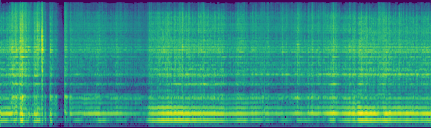

File: ../data/ESC-50/ESC-50-master/audio/5-220955-A-40.wav
Total Length: 5.0 seconds
Label: thunderstorm/helicopter / 4.04 / 0.02


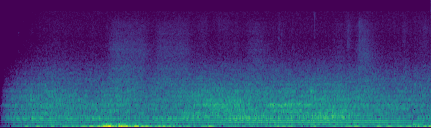

File: ../data/ESC-50/ESC-50-master/audio/5-223099-A-32.wav
Total Length: 5.0 seconds
Label: can_opening/keyboard_typing / 3.97 / 0.02


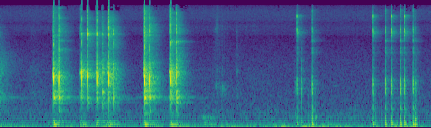

File: ../data/ESC-50/ESC-50-master/audio/5-207836-A-29.wav
Total Length: 5.0 seconds
Label: pig/drinking_sipping / 3.91 / 0.02


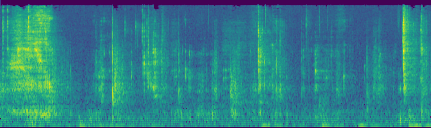

File: ../data/ESC-50/ESC-50-master/audio/5-181977-A-35.wav
Total Length: 5.0 seconds
Label: clock_tick/washing_machine / 3.87 / 0.02


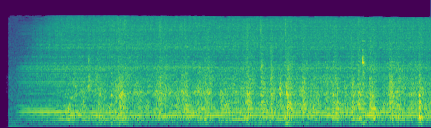

File: ../data/ESC-50/ESC-50-master/audio/5-204114-A-29.wav
Total Length: 5.0 seconds
Label: keyboard_typing/drinking_sipping / 3.78 / 0.02


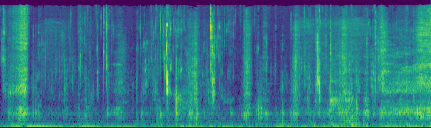

File: ../data/ESC-50/ESC-50-master/audio/5-205090-A-32.wav
Total Length: 5.0 seconds
Label: mouse_click/keyboard_typing / 3.68 / 0.03


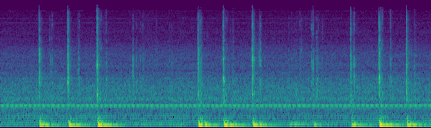

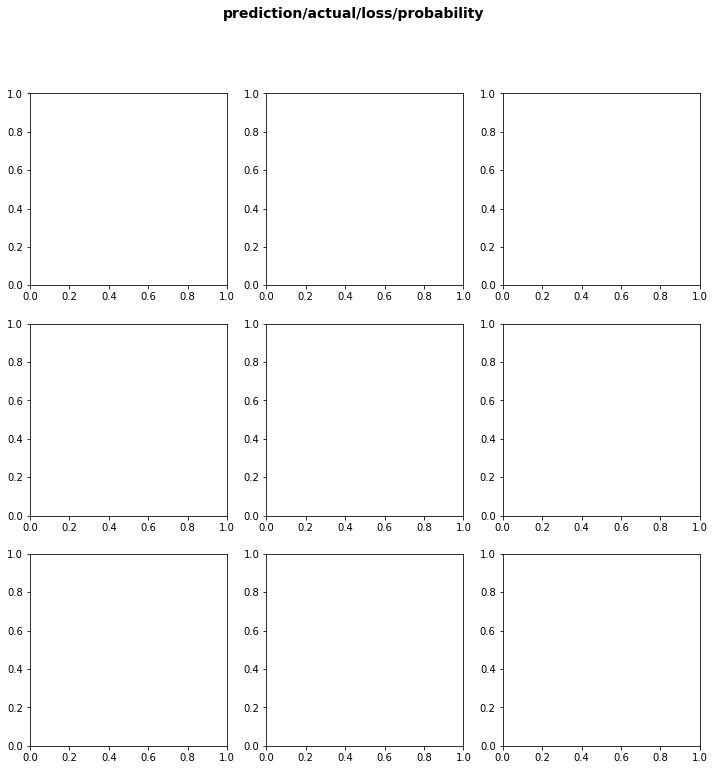

In [26]:
interp.plot_top_losses(9, heatmap=False)

## Step 2: Training on all folds

Because we have limited data, it is best practice to repeat the process cycling the validation fold to make sure we aren't just overfitting that one fold, we will repeat the process cycling the validation fold. For the sake of time, and because I clearly haven't figured out how to fine-tune mixup yet, and unfreeze/layer_groups might not be working on our learner, we will just do 100 epochs at 1e-2.

**Side note**: Sometimes you'll see this referred to as "k-folds validation" in kaggle competitions. The idea is that you split your data up into k (usually 5 or 10) different folds and then train models cycling the training/validation sets. The point is that by doing this on 5 folds, you'll have 5 different models that can then be used to perform inference, ensembling the various predictions. The cost is high though as you will increase your training time by 5x for a small gain. I also don't fully understand why this is better than just using 100% of your data and no validation once you have a training method you've already validated. If you can explain why, please post in the audio thread and I'll update/credit you here. 

In [30]:
results = []
fold_5_result = learn.validate()
results.append(fold_5_result)
results

[[0.52252144, tensor(0.8750)]]

In [34]:
#it is range(1,5), not range(1,6) because we already used fold 5 as validation fold
for VAL_FOLD in range(1,5):
    FILES_TRAIN = [f for f in DF.loc[DF['fold'] != VAL_FOLD].filename]
    FILES_TEST = [f for f in DF.loc[DF['fold'] == VAL_FOLD].filename]
    audio_train = AudioList.from_csv(PATH_AUDIO, PATH_CSV, config=cfg).split_by_files(FILES_TEST).label_from_df("category")
    db_audio = audio_train.transform(tfms=None).databunch(bs=16, num_workers=1)
    learn = cnn_learner(db_audio, models.densenet161, metrics=accuracy, callback_fns=ShowGraph, pretrained=True).mixup()
    learn.fit_one_cycle(100, slice(1e-2))
    results.append(learn.validate())
    print(results)

[[0.48709515, tensor(0.8850)], [0.51108325, tensor(0.8850)], [0.56737393, tensor(0.8625)], [0.90310854, tensor(0.9075)], [0.56284475, tensor(0.9025)]]


In [35]:
results

[[0.48709515, tensor(0.8850)],
 [0.51108325, tensor(0.8850)],
 [0.56737393, tensor(0.8625)],
 [0.90310854, tensor(0.9075)],
 [0.56284475, tensor(0.9025)]]

In [36]:
import pickle
with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [37]:
average_validation = sum([score for _, score in results])/5

In [38]:
average_validation

tensor(0.8885)

Note, the first time I ran this it produced the numbers above, but on loading the exported model and revalidating, it's accuracy on fold 5 was .8750, which would bring the overall average validation down to 0.8865